In [2]:
# Francisco Dominguez Mateos
# 12/07/2020
# SIREN for GON from pyTorch
# from: https://cwkx.github.io/data/GON/
#       https://www.youtube.com/watch?v=v-ZxzTSpmk4

In [1]:
import time
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import cv2

In [2]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

/home/francisco/anaconda3/envs/jax_gpu/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
def Siren(s=[1000]*5):
    def init_fun(key,input_shape):
        """ Initialize the weights of all layers of a linear layer network """
        sizes=[input_shape[-1]]+s
        print(sizes)
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, rng):
            scale=np.sqrt(6.0/float(m))
            w_key, b_key = random.split(key)
            return scale * random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        # actually they are pairs plus the random key
        pairs=zip(sizes[:-1], sizes[1:], keys)
        params=[initialize_layer(m, n, k) for m, n, k in pairs]
        params[0]=params[0][0]*30.0,params[0][1]
        output_shape =  input_shape[:-1] + (sizes[-1],)
        return (output_shape,params)
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        activations = inputs
        # Loop over the Siren hidden layers
        for w, b in params:
            linear = np.dot(w,activations)+b
            activations=np.sin(linear)
        return activations
    return init_fun, apply_fun

In [5]:
init,net=Siren([100]*5+[1])
input_shape=(-1,2)
output_shape,params=init(rng,input_shape)
print(output_shape)
for l in params:
    print(l[0].shape,l[1].shape)

[2, 100, 100, 100, 100, 100, 1]
(-1, 1)
(100, 2) (100,)
(100, 100) (100,)
(100, 100) (100,)
(100, 100) (100,)
(100, 100) (100,)
(1, 100) (1,)


In [6]:
# Make a batched version of the `net` function
batch_net = vmap(net, in_axes=(None, 0), out_axes=0)

In [7]:
def getInputOrdered(size):
    width=size[1]
    height=size[0]
    X, Y = np.meshgrid(range(height),range(width))
    X=X/height*2.0-1.0
    Y=Y/width *2.0-1.0
    xy=np.dstack((Y,X))
    input_ordered=np.reshape(xy,(-1,2))
    return input_ordered

def build_sdf(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width))

(2500, 2)
(2500, 1)
0.9999988 -0.9999995


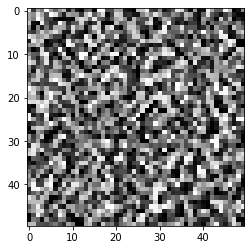

In [8]:
W=50
H=50
input_ordered=getInputOrdered((H,W))
img=build_sdf((H,W))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0,cmap='gray',)

In [9]:
@jit
def sdf_2d(point):
    x,y=point
    d0=x*x+y*y-0.30*0.30
    x1=x+0.3
    y1=y-0.3
    d1=x1*x1+y1*y1-0.15*0.15
    x2=x+0.3
    y2=y+0.3
    d2=x2*x2+y2*y2-0.15*0.15
    return d0 #np.min(np.array([d0,d1,d2]))
gsdf_2d=grad(sdf_2d)
print( sdf_2d((0.2,0.2)))
print(gsdf_2d((0.2,0.2)))
batch_sdf_2d =vmap( sdf_2d, in_axes=(None, 0), out_axes=0)
batch_gsdf_2d=vmap(gsdf_2d, in_axes=(None, 0), out_axes=0)

-0.01
(DeviceArray(0.4, dtype=float32), DeviceArray(0.4, dtype=float32))


In [10]:
#sdf_value=batch_sdf_2d(input_ordered)

In [11]:
mapped=list(map(sdf_2d,input_ordered))
sdf_values=np.reshape(np.array(mapped),(-1,1))
print(sdf_values.shape)
s=np.max(sdf_values)-np.min(sdf_values)
sdf_values/=s
print(np.max(sdf_values),np.min(sdf_values))

(2500, 1)
0.955 -0.045


In [12]:
gmapped=list(map(gsdf_2d,input_ordered))    
gsdf_values=np.reshape(np.array(gmapped),(-1,2))
print(gsdf_values.shape)

(2500, 2)


0.48979592 -0.5102041
(2500, 3)


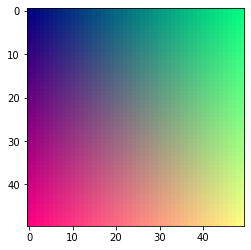

In [13]:
gmax=np.max(gsdf_values)
gmin=np.min(gsdf_values)
s=gmax-gmin
gsdf_values/=s
print(np.max(gsdf_values),np.min(gsdf_values))
z=np.zeros((gsdf_values.shape[0],1))
v=np.hstack((gsdf_values,z))
print(v.shape)
img=np.reshape(v,(H,W,3))
plt.imshow((img-np.min(gsdf_values)))

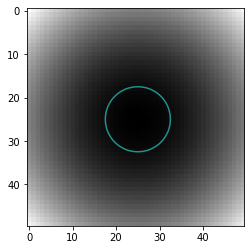

In [14]:
img=np.reshape(sdf_values,(H,W))
plt.imshow((img+1.0)/2.0,cmap="gray")
cs=plt.contour(range(H),range(W),img,0)
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

In [15]:
@jit
def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = batch_net(params, inputs)
    return np.mean((preds - targets)**2)
@jit
def accuracy(params,inputs,targets):
    return mse_loss(params,inputs,targets)
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [16]:
print(input_ordered.shape)
print(sdf_values.shape)
mse_loss(params,input_ordered,sdf_values)

(2500, 2)
(2500, 1)


DeviceArray(0.5517732, dtype=float32)

In [17]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [18]:
num_epochs = 1000
num_classes = 10

In [19]:
def run_training_loop(num_epochs, opt_state):
    global params
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params,input_ordered,sdf_values)
    test_acc  = accuracy(params,input_ordered,sdf_values)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss = update(params, input_ordered,sdf_values, opt_state)
        train_loss.append(loss)

        train_acc = accuracy(params,input_ordered,sdf_values)
        test_acc = accuracy(params,input_ordered,sdf_values)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        if(epoch %100 ==0):
            epoch_time = time.time() - start_time
            print("Epoch {} | T: {:0.3f} | Train A: {:0.4f} | Test A: {:0.4f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    return opt_state, train_loss, log_acc_train, log_acc_test

In [20]:
opt_state, train_loss, train_log, test_log =run_training_loop(num_epochs,opt_state)

Epoch 1 | T: 1.980 | Train A: 0.4008 | Test A: 0.4008
Epoch 101 | T: 0.040 | Train A: 0.0001 | Test A: 0.0001
Epoch 201 | T: 0.042 | Train A: 0.0000 | Test A: 0.0000
Epoch 301 | T: 0.040 | Train A: 0.0000 | Test A: 0.0000
Epoch 401 | T: 0.042 | Train A: 0.0000 | Test A: 0.0000
Epoch 501 | T: 0.042 | Train A: 0.0000 | Test A: 0.0000
Epoch 601 | T: 0.043 | Train A: 0.0000 | Test A: 0.0000
Epoch 701 | T: 0.042 | Train A: 0.0000 | Test A: 0.0000
Epoch 801 | T: 0.042 | Train A: 0.0000 | Test A: 0.0000
Epoch 901 | T: 0.042 | Train A: 0.0000 | Test A: 0.0000


(2500, 2)
(2500, 1)
0.9549903 -0.045000207


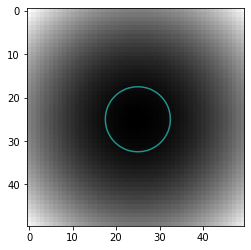

In [21]:
img=build_sdf((H,W))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0,cmap="gray")
cs=plt.contour(range(H),range(W),img,0)
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()